# Hill Climbing

---

In this notebook, we will implement a selection of simple policy-based methods with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [1]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Create an Agent

In [60]:
env = gym.make('CartPole-v0')
print('observation space:', env.observation_space)
print('action space:', env.action_space)
s_size = len(env.observation_space.high)
a_size = env.action_space.n

class Agent():
    """Interacts with the environment"""

    def __init__(self, state_size, action_size, pop_size=1, gamma=1, noise_scale=1e-2, noise_update=0.25, elite_frac=0.2, stoch_act=False, method="vanilla"):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            pop_size (int): number of new weights to compare each episode
            gamma (float): discount parameter
            noise_scale (int): amount of gaussian noise to add when updating weights
            noise_update (float): percentage to increase/decrease noise scale by (sim anneal and adapt noise_scale)
            elite_frac (float): percentage of top performers to use in update
            stoch_act (bool): if "True" will enable stochastic outputs for action values
            method (string):        "vanilla" = vanilla hill climbing
                                    "cross_ent" = cross entropy
                                    "steep_asc" = steepest ascent
                                    "evolution" = evolution strategy
                                    "adapt_noise_scale" = adaptive noise scaling
        """
        self.method = method
        self.gamma = gamma
        self.noise_scale = noise_scale
        self.noise_update = noise_update
        self.n_elite = int(pop_size*elite_frac)
        self.stoch_act = stoch_act
        self.state_size = state_size
        self.action_size = action_size
        self.pop_size = pop_size
        self.best_R = 0
        self.best_w = 1e-4*np.random.rand(state_size, action_size)
        self.new_w = 1e-4*np.random.rand(pop_size,state_size,action_size)

        # Raise a warning if an invalid method type is selected
        self.method_types = ["vanilla", "steep_asc", "sim_anneal", "cross_ent", "evolution", "adapt_noise_scale"]
        if self.method not in self.method_types:
            raise ValueError("Invalid sim type. Expected one of: %s" % self.method_types)
        if self.method == "vanilla" and self.pop_size > 1:
            raise ValueError("Invalid population size. For vanilla hill climbing 'pop_size' must equal 1")
        elif self.method != "vanilla" and self.pop_size == 1:
            raise ValueError(f"Cannot perform {self.method} with population size of 1. To learn with only one set of weights, select 'vanilla' for method.")

    def forward(self, state, n):
        """Completes a forward pass through network."""
        x = np.dot(state, self.new_w[n])
        return np.exp(x)/sum(np.exp(x))

    def act(self, state, n):
        """Returns the probability that an agent selects each action."""
        probs = self.forward(state, n)
        if self.stoch_act:
            action = np.random.choice(self.action_size, p=probs) # option 1: stochastic policy
        else:
            action = np.argmax(probs)              # option 2: deterministic policy
        return action

    def simulate_episode(self, max_t, initial_state, new_pop_size=None):
        """Simulates an episode from an initial_state and returns the rewards for that episode at each timestep."""
        pop_size = self.pop_size if new_pop_size is None else new_pop_size

        rewards = np.zeros((pop_size,max_t))
        for n in range(pop_size):
            env.reset()
            state = initial_state
            env.env.state = state
            for t in range(max_t):
                action = self.act(state, n)
                state, reward, done, _ = env.step(action)
                rewards[n][t] = reward
                if done:
                    break

        return rewards

    def apply_discounts(self, rewards, max_t, new_pop_size=None):
        """Returns a discounted sum of the rewards."""
        pop_size = self.pop_size if new_pop_size is None else new_pop_size
        discounts = [self.gamma**i for i in range(max_t)]
        discounted_rewards = np.empty((pop_size,max_t))
        for n in range(pop_size):
            discounted_rewards[n] = [a*b for a,b in zip(discounts, rewards[n])]
        summed_discounted_rewards = np.sum(discounted_rewards,axis=1)

        return summed_discounted_rewards

    def update(self, Rs, max_t, initial_state):
        """Updates the best reward and best weights. Then sets the new weights for the next episode."""
        if self.method == "vanilla":
            # If new rewards are better then the best weights update the weights
            if Rs >= self.best_R:
                self.best_R = Rs
                self.best_w = self.new_w
            self.new_w = self.best_w + (self.noise_scale * np.random.rand(*self.best_w.shape))

        elif self.method in ("steep_asc", "sim_anneal", "adapt_noise_scale"):
            new_best_R_idx = np.argmax(Rs)  # Get the index for the best rewards
            if Rs[new_best_R_idx] >= self.best_R:
                self.best_R = Rs[new_best_R_idx]
                self.best_w = self.new_w[new_best_R_idx]
                if self.method in ("sim_anneal", "adapt_noise_scale"):
                    # Decrease the noise perimeter if our rewards improved
                    self.noise_scale = self.noise_scale * (1 - self.noise_update)
            else:
                if self.method == "adapt_noise_scale":
                    # Increase our noise perimeter if our agent has stalled
                    self.noise_scale = self.noise_scale * (1 + self.noise_update)
            for n in range(self.pop_size):
                self.new_w[n] = self.best_w + (self.noise_scale * np.random.rand(*self.best_w.shape))

        elif self.method == "cross_ent":
            # Index our cumulative reward values and sort in descending order
            ranked_R_idx = np.argsort(-1*Rs)
            # Select the best scores and their corresponding weights
            elite_R_idx = ranked_R_idx[:self.n_elite]
            elite_ws = [self.new_w[idx,:,:] for idx in elite_R_idx]
            # Average the best weights and find their corresponding reward
            self.new_w = np.array(elite_ws).mean(axis=0)
            self.new_w = np.expand_dims(self.new_w,axis=0)

            # Run a simulation with our best averaged weights
            new_best_R = self.simulate_episode(max_t,initial_state,new_pop_size=1)
            new_best_discount_R = self.apply_discounts(new_best_R, max_t, new_pop_size=1)

            # Compare our new reward with our best reward and update weights
            if new_best_discount_R >= self.best_R:
                self.best_R = new_best_discount_R
                self.best_w = self.new_w.squeeze()
            self.new_w = np.zeros((self.pop_size,self.state_size,self.action_size))
            for n in range(self.pop_size):
                self.new_w[n] = self.best_w + (self.noise_scale * np.random.rand(*self.best_w.shape))


observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)


In [65]:
agent = Agent(s_size, a_size, method="cross_ent", pop_size=6, elite_frac=0.2)

def hill_climbing(n_episodes=1000, max_t=1000, print_every=1):
    """Implementation of hill climbing with adaptive noise scaling.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        noise_scale (float): standard deviation of additive noise
    """
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        initial_state = env.reset()   # Sets the initial state so that the agent can revisit it with different weights.
        rewards = agent.simulate_episode(max_t,initial_state)
        discounted_rewards = agent.apply_discounts(rewards,max_t)
        agent.update(discounted_rewards, max_t, initial_state)

        scores_deque.append(agent.best_R)
        scores.append(agent.best_R)

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            #agent.policy.w = agent.best_w
            break

    return scores

scores = hill_climbing()

Episode 1	Average Score: 134.00
Episode 2	Average Score: 167.00
Episode 3	Average Score: 178.00
Episode 4	Average Score: 183.50
Episode 5	Average Score: 186.80
Episode 6	Average Score: 189.00
Episode 7	Average Score: 190.57
Episode 8	Average Score: 191.75
Episode 9	Average Score: 192.67
Episode 10	Average Score: 193.40
Episode 11	Average Score: 194.00
Episode 12	Average Score: 194.50
Episode 13	Average Score: 194.92
Episode 14	Average Score: 195.29
Environment solved in 14 episodes!	Average Score: 195.29


### 4. Plot the Scores

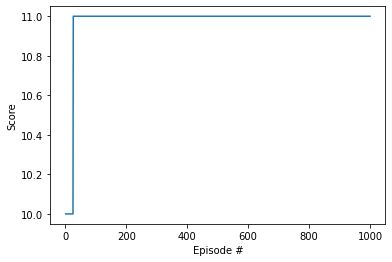

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [49]:
env = gym.make('CartPole-v0')
state = env.reset()
for t in range(200):
    action = agent.act(state, 0)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 

env.close()